# model.ipynb: 示例代码，建立两个决策树
这是示例代码，目的是为了让您更好地了解我们的算法。

方便起见，本notebook中只用了一个训练集，即`final-2.h5`。如果要使用全部的训练集，请参见`train.ipynb`。

为了能够更加清晰地展现出数据的处理过程，这里不用先跑预处理数据的代码`waveform.py`，而会将对数据的预处理放在代码块中。

本notebook的任务是训练出两个决策树：第一个的目标是每个waveform对应的PE数，即`modelPePerWF.txt`；第二个的目标是每个事件的动量p，即`modelP.txt`。

训练完之后，运行`final.ipynb`，便可以得到最终的答案。

In [47]:
import multiprocessing
import warnings # 临时需要，没有的话有一步代码会疯狂爆mean一个空数组的warning，其实这是正常情况
import numpy as np
import h5py
import matplotlib.pyplot as plt
%matplotlib inline
from utils import loadData, getNum, getPePerWF, saveData, lossfunc_train, lossfunc_eval
from tqdm import tqdm # 展示进度条
import lightgbm as lgb # 训练决策树使用的包

指定__训练集__的位置。git仓库中并没有data这个文件夹，需要手动创建，并将数据集下载到该目录下。\
这一步可能需要一分钟左右。结束后会展示读进来的三个表的信息。

In [48]:
trainPath = "./data/final-2.h5" # 指定训练集位置

# trainPET是PETruth表，trainWF是Waveform表，trainPT是ParticleTruth表
trainPET, trainWF, trainPT = loadData(trainPath, 'PT')

Structure of data:
<HDF5 dataset "PETruth": shape (9137011,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (2000,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (6041164,), type "|V2008"> Waveform /Waveform


为了训练第二个决策树，我们需要将属于一个Event的PE或Waveform分开。

这里调用了`utils.py`中定义的`getNum`函数。得到的`peIndices`是一个$(n+1,)$的ndarray，$n$表示训练集的EventID数。当$i<n$时，`peIndices[i]`表示EventID为$i$对应第一个PE或Waveform的index；当$i=n$时，`peIndices[i]`表示训练集的总行数。`wfIndices`是类似的。

为什么要$n+1$呢？~历史上是因为这样能更方便地得到`numPET`~因为如果需要将18个训练集拼接成一个训练集，就会方便很多。详见`train.ipynb`。

`numPET`和`numPEW`都是$(n,)$的ndarray，下标为$i$各表示EventID为$i$时的PE数和波形数。这两个变量后面并没有用到，因为历史原因保留在这里。

In [49]:
numPET, peIndices = getNum(trainPET)
numPEW, wfIndices = getNum(trainWF)

为了训练，需要得到每个waveform对应的pe数`pePerTrainWF`，作为真值。

In [50]:
pePerTrainWF = np.array([], dtype=int)
splitWFChannels = np.split(trainWF['ChannelID'], wfIndices[1:-1])
for index, arr in enumerate(tqdm(np.split(trainPET['ChannelID'], peIndices[1:-1]))):
    channels, counts = np.unique(arr, return_counts=True)
    
    # 上面得到的counts并不能直接用，因为需要为暗触发的waveform补0

    # 使用isin得到counts虽然很简洁，但似乎略慢于傻傻地使用while，原因不明。
    # indicesToInsert = np.isin(splitWFChannels[index], channels, invert=True).nonzero()[0]
    # for indexToInsert in indicesToInsert:
        # counts = np.insert(counts, indexToInsert, 0) #注意不能一次性insert了，要用for循环，因为可能会越界访问。

    zeroPeChannelCount = numPEW[index].astype(int) - channels.shape[0]
    while zeroPeChannelCount:
        alignedChannels = np.append(channels, np.zeros(zeroPeChannelCount)-1)
        indexToInsert = np.asarray(alignedChannels != splitWFChannels[index]).nonzero()[0][0]
        channels = np.insert(channels, indexToInsert, splitWFChannels[index][indexToInsert])
        counts = np.insert(counts, indexToInsert, 0)
        zeroPeChannelCount -= 1
    
    pePerTrainWF = np.append(pePerTrainWF, counts)

pePerTrainWF = pePerTrainWF.flatten().astype(int)
# peTimesPerTrainWF = np.split(trainPET['PETime'], np.cumsum(pePerTrainWF))[:-1]

100%|██████████| 2000/2000 [00:12<00:00, 157.32it/s]


去除`TrainWF`的噪声：设置下限为918，小于918的认为是有意义的信息，大于等于918的认为是噪声。

为什么是918？这是我盯着一大堆waveform看出来的经验常数（误）

In [51]:
denoisedTrainWF = np.where(trainWF['Waveform'] < 918, 918-trainWF['Waveform'], 0)

对于denoisedTrainWF数据，取出三个feature，目的是找到每个波形对应多少个PE。
1. 波形的积分`intTrainWF`
2. 超出阈值的波形点数`pointsPerTrainWF`
3. 手动处理，得到的每个波形对应的PE`pePerTrainWFCalc`

除此之外，用手动方式得到每个波形对应的PETime的平均值`meanPeTimePerTrainWF`，以后需要用到。

In [52]:
intTrainWF = np.sum(denoisedTrainWF, axis=1)
pointsPerTrainWF = np.sum(denoisedTrainWF > 0, axis=1)

简单介绍一下手作算法：
1. 对一个波形，反复`np.argmax`，找到最大值对应的index后，认为这是一次PE所在的位置；
2. 将波形减去一个峰值在argmax处的取消函数（表示一个PE产生的效果）；
3. 在取消函数不为0的区域，判断纵坐标是否小于一个特定的值，如果是则认为是噪声，置为0；
4. 重复1-3的操作，直到波形的积分小于某个特定值，或者超过0的点小于某个特定值为止；
5. 最后得到一个`wfArgmax`数组，对这个数组，取长度`PePerTrainWFCalc`与去除部分暗噪声（argmax小于特定值或大于特定值）的平均值减去一个常数14.5(还是经验常数，差不多等于PETime)`meanPeTimePerTrainWF`，作为返回值。

实际使用的手作算法略复杂于上面的描述，详见`utils.py`中定义的`getPePerWF`。

这里有很多参数可以调，可以使用以下的代码观察当前手作算法的效果。

PE真值是1
积分是88
超出阈值的点是17
结果是(1, 409.0)


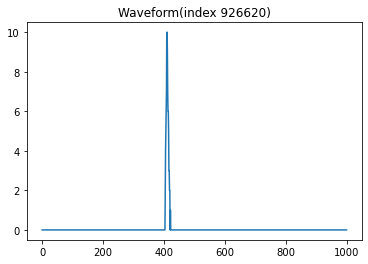

In [53]:
randIndex = np.random.randint(0, denoisedTrainWF.shape[0]-1) # 随机取一个波形
res = getPePerWF(denoisedTrainWF[randIndex])
print(f"PE真值是{pePerTrainWF[randIndex]}")
print(f"积分是{intTrainWF[randIndex]}")
print(f"超出阈值的点是{pointsPerTrainWF[randIndex]}")
print(f"结果是{res}")
plt.plot(denoisedTrainWF[randIndex])
plt.title(f"Waveform(index {randIndex})")
plt.show()

这是正式处理训练集的代码。手作算法比较慢，取决于计算机速度，可能会花费20分钟左右。

注意，如果没有`warnings.simplefilter("ignore")`，会导致疯狂爆mean一个空数组的warning。这是由于一个waveform可能全是暗噪声，或者根本就是暗触发，导致手作算法根本没有运行argmax（这也是正确的表现）。后面的代码会处理nan，所以这里忽略warning。

In [54]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    with multiprocessing.Pool(8) as p: # 开了八个进程，视cpu情况，可以将8改为适合当前cpu的值
        res = np.array(
            list(tqdm(
                p.imap(
                    getPePerWF,
                    denoisedTrainWF
                ), total=denoisedTrainWF.shape[0]
            ))
        )

pePerTrainWFCalc = res[:, 0]
meanPeTimePerTrainWF = res[:, 1]

100%|██████████| 6041164/6041164 [15:48<00:00, 6368.68it/s]


下面检验三个feature对于真正的`pePerTrainWF`的关系，画出三个散点图：

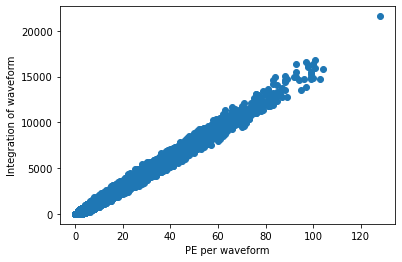

In [55]:
plt.scatter(pePerTrainWF, intTrainWF)
plt.xlabel("PE per waveform")
plt.ylabel("Integration of waveform")
plt.show()

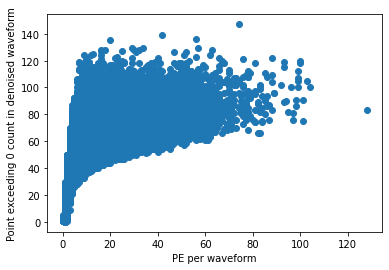

In [56]:
plt.scatter(pePerTrainWF, pointsPerTrainWF)
plt.xlabel("PE per waveform")
plt.ylabel("Point exceeding 0 count in denoised waveform")
plt.show()

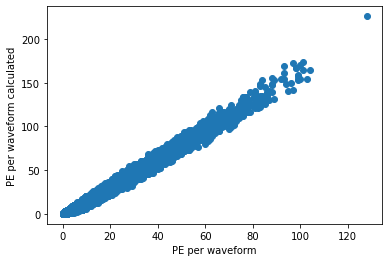

In [57]:
plt.scatter(pePerTrainWF, pePerTrainWFCalc)
plt.xlabel("PE per waveform")
plt.ylabel("PE per waveform calculated")
plt.show()

使用LightGBM，训练从以上三个feature到`pePerTrainWF`的决策树。

先创建训练集与验证集，然后存储到二进制文件中，这样可以加快训练速度，且易于代码复用。这里使用了最后50万组数据作为验证集，前面的为训练集。

In [58]:
trainDataForPePerWF = lgb.Dataset(
    np.stack(
        (intTrainWF[:-500000], pointsPerTrainWF[:-500000], pePerTrainWFCalc[:-500000]),
        axis=1
    ),
    label=pePerTrainWF[:-500000],
)
validationDataForPePerWF = lgb.Dataset(
    np.stack(
        (intTrainWF[-500000:], pointsPerTrainWF[-500000:], pePerTrainWFCalc[-500000:]),
        axis=1
    ),
    label=pePerTrainWF[-500000:],
    reference=trainDataForPePerWF,
)
trainDataForPePerWF.save_binary('./train/trainPePerWFPlay.bin')
validationDataForPePerWF.save_binary('./train/validPePerWFPlay.bin')

[LightGBM] [Warning] File ./train/trainPePerWFPlay.bin exists, cannot save binary to it
[LightGBM] [Warning] File ./train/validPePerWFPlay.bin exists, cannot save binary to it


/home/zhaohaimeng/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')


开始训练决策树！最终将结果存在`modelPePerWFPlay.txt`中。

In [59]:
trainDataForPePerWF = lgb.Dataset('./train/trainPePerWFPlay.bin')
validationDataForPePerWF = lgb.Dataset('./train/validPePerWFPlay.bin', reference=trainDataForPePerWF)
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'rmse'},
    'num_leaves': 2**11,
    'learning_rate': 0.01,
    'feature_fraction': 1,
    'bagging_fraction': 1,
    'bagging_freq': 5,
    'verbose': 0,
    'num_threads': 20,
    'max_depth': 20,
}
gbmForPePerWF = lgb.train(
    params,
    trainDataForPePerWF,
    num_boost_round=3000,
    valid_sets=validationDataForPePerWF,
    early_stopping_rounds=300,
)
gbmForPePerWF.save_model('modelPePerWFPlay.txt')

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047492 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[1]	valid_0's rmse: 1.76336
Training until validation scores don't improve for 300 rounds
[2]	valid_0's rmse: 1.74613
[3]	valid_0's rmse: 1.72907
[4]	valid_0's rmse: 1.71219
[5]	valid_0's rmse: 1.69548
[6]	valid_0's rmse: 1.67894
[7]	valid_0's rmse: 1.66257
[8]	valid_0's rmse: 1.64638
[9]	valid_0's rmse: 1.63034
[10]	valid_0's rmse: 1.61448
[11]	valid_0's rmse: 1.59877
[12]	valid_0's rmse: 1.58323
[13]	valid_0's rmse: 1.56785
[14]	valid_0's rmse: 1.55263
[15]	valid_0's rmse: 1.53756
[16]	valid_0's rmse: 1.52265
[17]	valid_0's rmse: 1.50789
[18]	valid_0's rmse: 1.49329
[19]	valid_0's rmse: 1.47883
[20]	valid_0's rmse: 1.46453
[21]	valid_0's rmse: 1.45037
[22]	valid_0's rmse: 1.43636
[23]	valid_0's rmse: 1.4225
[24]	valid_0's rmse: 1.40878
[25]	valid_0's rmse: 1.

[263]	valid_0's rmse: 0.301226
[264]	valid_0's rmse: 0.300721
[265]	valid_0's rmse: 0.300227
[266]	valid_0's rmse: 0.299743
[267]	valid_0's rmse: 0.299265
[268]	valid_0's rmse: 0.298797
[269]	valid_0's rmse: 0.298336
[270]	valid_0's rmse: 0.297887
[271]	valid_0's rmse: 0.297447
[272]	valid_0's rmse: 0.297012
[273]	valid_0's rmse: 0.296587
[274]	valid_0's rmse: 0.296169
[275]	valid_0's rmse: 0.29576
[276]	valid_0's rmse: 0.295357
[277]	valid_0's rmse: 0.294963
[278]	valid_0's rmse: 0.294578
[279]	valid_0's rmse: 0.294198
[280]	valid_0's rmse: 0.293826
[281]	valid_0's rmse: 0.29346
[282]	valid_0's rmse: 0.293101
[283]	valid_0's rmse: 0.292752
[284]	valid_0's rmse: 0.292407
[285]	valid_0's rmse: 0.292068
[286]	valid_0's rmse: 0.291739
[287]	valid_0's rmse: 0.291413
[288]	valid_0's rmse: 0.291092
[289]	valid_0's rmse: 0.290781
[290]	valid_0's rmse: 0.290476
[291]	valid_0's rmse: 0.290174
[292]	valid_0's rmse: 0.289879
[293]	valid_0's rmse: 0.289588
[294]	valid_0's rmse: 0.289306
[295]	vali

[529]	valid_0's rmse: 0.275962
[530]	valid_0's rmse: 0.275962
[531]	valid_0's rmse: 0.275965
[532]	valid_0's rmse: 0.275964
[533]	valid_0's rmse: 0.275963
[534]	valid_0's rmse: 0.275962
[535]	valid_0's rmse: 0.275961
[536]	valid_0's rmse: 0.275961
[537]	valid_0's rmse: 0.27596
[538]	valid_0's rmse: 0.27596
[539]	valid_0's rmse: 0.27596
[540]	valid_0's rmse: 0.27596
[541]	valid_0's rmse: 0.27596
[542]	valid_0's rmse: 0.27596
[543]	valid_0's rmse: 0.275958
[544]	valid_0's rmse: 0.275958
[545]	valid_0's rmse: 0.275958
[546]	valid_0's rmse: 0.275958
[547]	valid_0's rmse: 0.275958
[548]	valid_0's rmse: 0.275958
[549]	valid_0's rmse: 0.275958
[550]	valid_0's rmse: 0.275956
[551]	valid_0's rmse: 0.275954
[552]	valid_0's rmse: 0.275953
[553]	valid_0's rmse: 0.275957
[554]	valid_0's rmse: 0.275955
[555]	valid_0's rmse: 0.275955
[556]	valid_0's rmse: 0.275959
[557]	valid_0's rmse: 0.275957
[558]	valid_0's rmse: 0.275958
[559]	valid_0's rmse: 0.275961
[560]	valid_0's rmse: 0.275963
[561]	valid_0'

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[744]	valid_0's rmse: 0.276202
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[745]	valid_0's rmse: 0.276206
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[746]	valid_0's rmse: 0.276205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[747]	valid_0's rmse: 0.276209
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[748]	valid_0's rmse: 0.27621
[749]	valid_0's rmse: 0.276214
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[750]	valid_0's rmse: 0.276215
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[751]	valid_0's rmse: 0.276213
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[752]	valid_0's rmse: 0.276214
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[753]	valid_0's rmse: 0.276214
[754]	valid_0's 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[825]	valid_0's rmse: 0.276254
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[826]	valid_0's rmse: 0.276258
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[827]	valid_0's rmse: 0.276257
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[828]	valid_0's rmse: 0.276256
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[829]	valid_0's rmse: 0.276259
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[830]	valid_0's rmse: 0.276258
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[831]	valid_0's rmse: 0.276261
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[832]	valid_0's rmse: 0.27626
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[833]	valid_0's rmse: 0.276264
[LightGBM] [Warning] No further splits with pos

下面来观察一下决策树的预测能力。使用决策树，将全体数据输入，让其预测`pePerTrainWF`，并与真值相比较，画出散点图。

print的tuple表示三个特征在决策树中起到的作用大小。

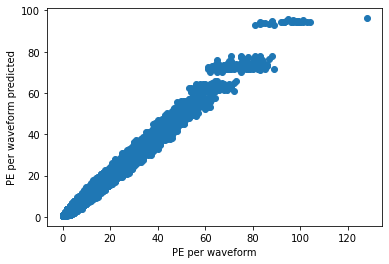

[340473 681990 177079]


In [60]:
gbmForPePerWF = lgb.Booster(model_file='./modelPePerWFPlay.txt')
pePerTrainWFFinal = gbmForPePerWF.predict(
    np.stack(
        (intTrainWF, pointsPerTrainWF, pePerTrainWFCalc),
        axis=1
    )
)
plt.scatter(pePerTrainWF, pePerTrainWFFinal)
plt.xlabel("PE per waveform")
plt.ylabel("PE per waveform predicted")
plt.show()
print(gbmForPePerWF.feature_importance())

下面开始训练第二个决策树。我们使用了五个feature：
1. 单个事件的PE总数（由第一个决策树计算得到）`peTotal`；
2. 对于单个事件，每个触发的channel都有一个PE总数，取这些的平均值`peMean`；
3. 将2中的平均值改为标准差`peStd`；
4. 对于单个事件，每个触发的channel能够用手作算法得到一个PETime平均值，取这些的平均值`peTimeMean`;
5. 将4中的平均值改为标准差`peTimeStd`

我们按照事件数，将属于不同事件的`pePerTrianWFFinal`分开，然后得到这五个feature。

In [61]:
splitPePerTrainWFFinal = np.split(pePerTrainWFFinal, wfIndices[1:-1].astype(int))
p = trainPT['p']
peTotal = np.empty(p.shape[0])
peMean = np.empty(p.shape[0])
peStd = np.empty(p.shape[0])
for index, pePerTrainWFFinalChunk in enumerate(tqdm(splitPePerTrainWFFinal)):
    peTotal[index] = np.sum(pePerTrainWFFinalChunk)
    peMean[index] = np.mean(pePerTrainWFFinalChunk)
    peStd[index] = np.std(pePerTrainWFFinalChunk)

splitMeanPeTimePerTrainWF = np.split(meanPeTimePerTrainWF, wfIndices[1:-1])
peTimeMean = np.empty(p.shape[0])
peTimeStd = np.empty(p.shape[0])
for index, meanPeTimePerTrainWFFinalChunk in enumerate(tqdm(splitMeanPeTimePerTrainWF)):
    peTimeMean[index] = np.nanmean(meanPeTimePerTrainWFFinalChunk)
    peTimeStd[index] = np.nanstd(meanPeTimePerTrainWFFinalChunk)


100%|██████████| 2000/2000 [00:00<00:00, 4915.01it/s]


训练第二个决策树，并且存储到`modelPPlay.txt`

In [62]:
trainDataForP = lgb.Dataset(
    np.stack(
        (peTotal[:-200], peMean[:-200], peStd[:-200], peTimeMean[:-200], peTimeStd[:-200]),
        axis=1
    ),
    label=p[:-200]
)
validationDataForP = lgb.Dataset(
    np.stack(
        (peTotal[-200:], peMean[-200:], peStd[-200:], peTimeMean[-200:], peTimeStd[-200:]),
        axis=1
    ),
    label=p[-200:],
    reference=trainDataForP
)
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'rmse'},
    'num_leaves': 2**11,
    'learning_rate': 0.01,
    'feature_fraction': 1,
    'bagging_fraction': 1,
    'bagging_freq': 5,
    'verbose': 0,
    'num_threads': 20,
    'max_depth': -1,
}
gbmForP = lgb.train(
    params,
    trainDataForP,
    num_boost_round=3000,
    valid_sets=validationDataForP,
    early_stopping_rounds=300,
    fobj=lossfunc_train,
    feval=lossfunc_eval
)
gbmForP.save_model('modelPPlay.txt')

[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's rmse: 6.19265	valid_0's custom: 5.34347
Training until validation scores don't improve for 300 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's rmse: 6.13093	valid_0's custom: 5.23714
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's rmse: 6.06968	valid_0's custom: 5.13289
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's rmse: 6.00922	valid_0's custom: 5.03079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's rmse: 5.94923	valid_0's custom: 4.93069
[LightGBM]

[61]	valid_0's rmse: 3.40251	valid_0's custom: 1.60946
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[62]	valid_0's rmse: 3.36888	valid_0's custom: 1.57774
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[63]	valid_0's rmse: 3.33577	valid_0's custom: 1.54685
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[64]	valid_0's rmse: 3.30284	valid_0's custom: 1.51647
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[65]	valid_0's rmse: 3.27018	valid_0's custom: 1.4866
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[66]	valid_0's rmse: 3.2381	valid_0's custom: 1.45757
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[67]	valid_0's rmse: 3.20613	valid_0's custom: 1.42888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[68]	valid_0's rmse: 3.17466	valid_0's custom: 1.40092
[LightGBM] [Warning] No further split

[129]	valid_0's rmse: 1.7387	valid_0's custom: 0.42032
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[130]	valid_0's rmse: 1.72174	valid_0's custom: 0.412179
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[131]	valid_0's rmse: 1.70487	valid_0's custom: 0.404153
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[132]	valid_0's rmse: 1.68829	valid_0's custom: 0.396348
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[133]	valid_0's rmse: 1.67181	valid_0's custom: 0.388678
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[134]	valid_0's rmse: 1.6555	valid_0's custom: 0.381169
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[135]	valid_0's rmse: 1.63951	valid_0's custom: 0.373845
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[136]	valid_0's rmse: 1.62355	valid_0's custom: 0.366613
[LightGBM] [Warning] N

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[195]	valid_0's rmse: 0.922506	valid_0's custom: 0.119592
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[196]	valid_0's rmse: 0.913935	valid_0's custom: 0.117424
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[197]	valid_0's rmse: 0.905384	valid_0's custom: 0.115292
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[198]	valid_0's rmse: 0.897014	valid_0's custom: 0.113216
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[199]	valid_0's rmse: 0.888703	valid_0's custom: 0.111173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[200]	valid_0's rmse: 0.880432	valid_0's custom: 0.109165
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[201]	valid_0's rmse: 0.872212	valid_0's custom: 0.107191
[LightGBM] [Warning] No further splits with positive gain, best gain:

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[260]	valid_0's rmse: 0.515333	valid_0's custom: 0.03976
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[261]	valid_0's rmse: 0.511081	valid_0's custom: 0.0391875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[262]	valid_0's rmse: 0.506851	valid_0's custom: 0.038622
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[263]	valid_0's rmse: 0.50264	valid_0's custom: 0.0380386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[264]	valid_0's rmse: 0.498495	valid_0's custom: 0.0374947
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[265]	valid_0's rmse: 0.494391	valid_0's custom: 0.0369615
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[266]	valid_0's rmse: 0.49032	valid_0's custom: 0.0364117
[LightGBM] [Warning] No further splits with positive gain, best gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[322]	valid_0's rmse: 0.32451	valid_0's custom: 0.0187891
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[323]	valid_0's rmse: 0.322485	valid_0's custom: 0.0186294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[324]	valid_0's rmse: 0.32044	valid_0's custom: 0.0184659
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[325]	valid_0's rmse: 0.318448	valid_0's custom: 0.0183094
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[326]	valid_0's rmse: 0.316457	valid_0's custom: 0.018155
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[327]	valid_0's rmse: 0.314469	valid_0's custom: 0.0179862
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[328]	valid_0's rmse: 0.312561	valid_0's custom: 0.0178402
[LightGBM] [Warning] No further splits with positive gain, best g

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[388]	valid_0's rmse: 0.234071	valid_0's custom: 0.0123684
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[389]	valid_0's rmse: 0.233228	valid_0's custom: 0.0123155
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[390]	valid_0's rmse: 0.232401	valid_0's custom: 0.0122848
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[391]	valid_0's rmse: 0.231616	valid_0's custom: 0.0122334
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[392]	valid_0's rmse: 0.230814	valid_0's custom: 0.0122044
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[393]	valid_0's rmse: 0.230019	valid_0's custom: 0.012155
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[394]	valid_0's rmse: 0.229274	valid_0's custom: 0.0121286
[LightGBM] [Warning] No further splits with positive gain, best

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[455]	valid_0's rmse: 0.199365	valid_0's custom: 0.0105653
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[456]	valid_0's rmse: 0.199081	valid_0's custom: 0.0105465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[457]	valid_0's rmse: 0.198791	valid_0's custom: 0.0105301
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[458]	valid_0's rmse: 0.198523	valid_0's custom: 0.0105203
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[459]	valid_0's rmse: 0.198249	valid_0's custom: 0.0105029
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[460]	valid_0's rmse: 0.197977	valid_0's custom: 0.0104871
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[461]	valid_0's rmse: 0.19771	valid_0's custom: 0.0104779
[LightGBM] [Warning] No further splits with positive gain, best

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[523]	valid_0's rmse: 0.186645	valid_0's custom: 0.00991623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[524]	valid_0's rmse: 0.186548	valid_0's custom: 0.00991727
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[525]	valid_0's rmse: 0.186439	valid_0's custom: 0.00990995
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[526]	valid_0's rmse: 0.186346	valid_0's custom: 0.00990702
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[527]	valid_0's rmse: 0.186253	valid_0's custom: 0.00990823
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[528]	valid_0's rmse: 0.186157	valid_0's custom: 0.00990919
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[529]	valid_0's rmse: 0.186063	valid_0's custom: 0.00990274
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[638]	valid_0's rmse: 0.179966	valid_0's custom: 0.0095248
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[639]	valid_0's rmse: 0.179953	valid_0's custom: 0.00952099
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[640]	valid_0's rmse: 0.179916	valid_0's custom: 0.0095212
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[641]	valid_0's rmse: 0.179883	valid_0's custom: 0.00951882
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[642]	valid_0's rmse: 0.179899	valid_0's custom: 0.00951658
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[643]	valid_0's rmse: 0.179858	valid_0's custom: 0.0095146
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[644]	valid_0's rmse: 0.179852	valid_0's custom: 0.00951522
[LightGBM] [Warning] No further splits with positive gain,

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[753]	valid_0's rmse: 0.178	valid_0's custom: 0.00929705
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[754]	valid_0's rmse: 0.178017	valid_0's custom: 0.00930144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[755]	valid_0's rmse: 0.178026	valid_0's custom: 0.00930785
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[756]	valid_0's rmse: 0.178006	valid_0's custom: 0.00930437
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[757]	valid_0's rmse: 0.178018	valid_0's custom: 0.00930845
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[758]	valid_0's rmse: 0.178027	valid_0's custom: 0.00931411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[759]	valid_0's rmse: 0.178031	valid_0's custom: 0.00932013
[LightGBM] [Warning] No further splits with positive gain,

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[864]	valid_0's rmse: 0.178325	valid_0's custom: 0.00938459
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[865]	valid_0's rmse: 0.178303	valid_0's custom: 0.00938449
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[866]	valid_0's rmse: 0.178322	valid_0's custom: 0.00939008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[867]	valid_0's rmse: 0.178323	valid_0's custom: 0.00938573
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[868]	valid_0's rmse: 0.178329	valid_0's custom: 0.00938692
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[869]	valid_0's rmse: 0.178318	valid_0's custom: 0.00938095
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[870]	valid_0's rmse: 0.178333	valid_0's custom: 0.00938238
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[976]	valid_0's rmse: 0.178772	valid_0's custom: 0.00945777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[977]	valid_0's rmse: 0.178762	valid_0's custom: 0.00946008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[978]	valid_0's rmse: 0.178742	valid_0's custom: 0.0094561
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[979]	valid_0's rmse: 0.178718	valid_0's custom: 0.00945809
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[980]	valid_0's rmse: 0.178747	valid_0's custom: 0.00946569
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[981]	valid_0's rmse: 0.178729	valid_0's custom: 0.00946805
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[982]	valid_0's rmse: 0.178723	valid_0's custom: 0.00946945
[LightGBM] [Warning] No further splits with positive gai

下面来观察一下决策树的预测能力。使用决策树，将全体数据输入，让其预测`p`，并与真值相比较，画出散点图。

print的tuple表示五个特征在决策树中起到的作用大小。

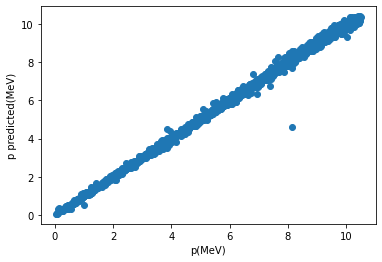

[14615  9431  8522 10580 10103]


In [63]:
plt.scatter(
    p,
    gbmForP.predict(
        np.stack(
            (peTotal, peMean, peStd, peTimeMean, peTimeStd),
            axis=1
        )
    )
)
plt.xlabel("p(MeV)")
plt.ylabel("p predicted(MeV)")
plt.show()
print(gbmForP.feature_importance())